## Imports

In [2]:
!apt install -y ffmpeg  # for GIF creation
!pip install ffmpeg     # P.S needs internet on

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=eb36930ea62c54dafd489052b4bd39e66352045dad973014d9e79927430de5f9
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg


In [1]:
import torch
import torchvision.datasets  as dsets
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

import tqdm
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, FileLink

### Data

In [3]:
batch_size = 64
image_size = 64
num_epochs = 10
torch.cuda.set_device("cuda:0")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ml2021/anime.zip

In [6]:
dset = dsets.ImageFolder(root="/content/anime/",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
# cut the size of the dataset
dataset, _ = torch.utils.data.random_split(dset, [len(dset)//2, len(dset)-len(dset)//2])
del _
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

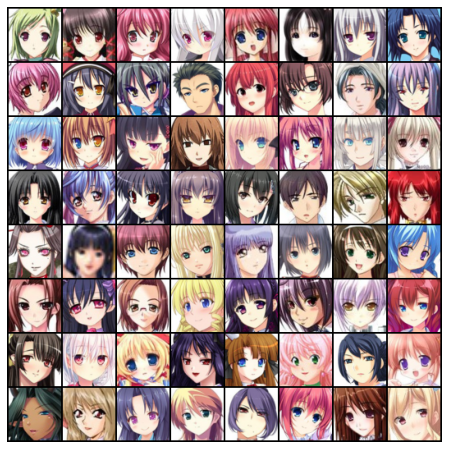

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2).cpu(),(1,2,0)))

### Model

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [10]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [11]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),
                                 x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## training

In [12]:
model = VAE(z_dim=128)
try:
    model.load_state_dict(torch.load("/content/drive/MyDrive/ml2021/vae_anime128.pth"))
except:
    print("Weights not found ):")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    torch.save(model.state_dict(), "/content/drive/MyDrive/ml2021/vae_anime128.pth")
    print('epoch %d, loss %.7f' % (epoch, train_loss / len(dataset)))
model.eval()

100%|██████████| 993/993 [05:22<00:00,  3.08it/s]


epoch 0, loss 6493.8875730


100%|██████████| 993/993 [05:21<00:00,  3.08it/s]


epoch 1, loss 6487.0262875


100%|██████████| 993/993 [05:21<00:00,  3.09it/s]


epoch 2, loss 6481.9072549


100%|██████████| 993/993 [05:23<00:00,  3.07it/s]


epoch 3, loss 6478.3387806


100%|██████████| 993/993 [05:21<00:00,  3.09it/s]


epoch 4, loss 6474.9658002


100%|██████████| 993/993 [05:21<00:00,  3.09it/s]


epoch 5, loss 6471.7205263


100%|██████████| 993/993 [05:20<00:00,  3.10it/s]


epoch 6, loss 6469.0882300


100%|██████████| 993/993 [05:23<00:00,  3.07it/s]


epoch 7, loss 6466.3982212


100%|██████████| 993/993 [05:22<00:00,  3.08it/s]


epoch 8, loss 6463.7354394


100%|██████████| 993/993 [05:22<00:00,  3.08it/s]

epoch 9, loss 6461.5076891


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (h2mu): Linear(in_features=1024, out_features=128, bias=True)
  (h2sigma): Linear(in_features=1024, out_features=128, bias=True)
  (z2h): Linear(in_features=128, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)

### Visualizations time!

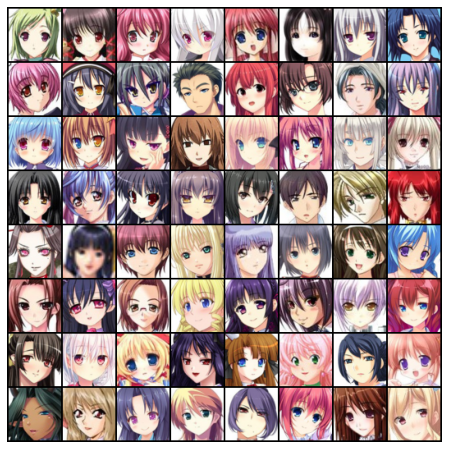

In [15]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2).cpu(),(1,2,0)))

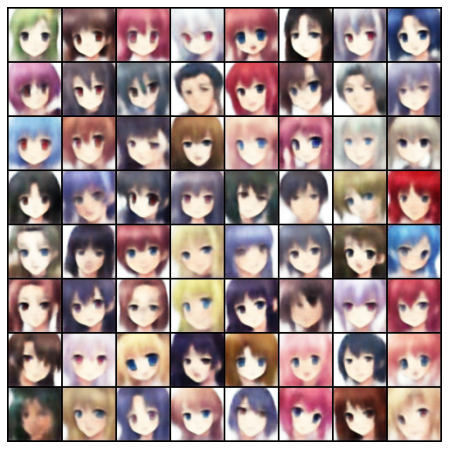

In [16]:
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch, padding=2).cpu(),(1,2,0)))

# Создадим гифку

In [13]:
def get(x):
    return dataset[x][0].view(1, 3, image_size, image_size)

def imshow(img):
    pic = np.transpose(img.numpy(), (1,2,0))
    plt.axis('off')
    return plt.imshow(pic, animated=True)

def morph(inputs, steps: int, delay: int):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data[0]
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

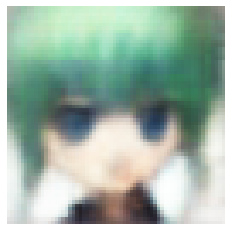

In [14]:
num_images = 30 # amount of images in GIF
num_steps = 20 # smoothness of transition between images
delay = 30
morph(np.random.randint(0, len(dataset), num_images), num_steps, delay)